In [206]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import optimize
import ipywidgets as widgets

# 1. Human capital accumulation

Consider a worker living in **two periods**, $t \in \{1,2\}$. 

In each period she decides whether to **work ($l_t = 1$) or not ($l_t = 0$)**. 

She can *not* borrow or save and thus **consumes all of her income** in each period. 

If she **works** her **consumption** becomes:

$$c_t = w h_t l_t\,\,\text{if}\,\,l_t=1$$

where $w$ is **the wage rate** and $h_t$ is her **human capital**. 

If she does **not work** her consumption becomes:

$$c_t = b\,\,\text{if}\,\,l_t=0$$

where $b$ is the **unemployment benefits**.

Her **utility of consumption** is: 

$$ \frac{c_t^{1-\rho}}{1-\rho} $$

Her **disutility of working** is:

$$ \gamma l_t $$

From period 1 to period 2, she **accumulates human capital** according to:

$$ h_2 = h_1 + l_1 + 
\begin{cases}
0 & \text{with prob. }0.5 \\
\Delta & \text{with prob. }0.5 
\end{cases} \\
$$

where $\Delta$ is a **stochastic experience gain**.

In the **second period** the worker thus solves:

$$
\begin{eqnarray*}
v_{2}(h_{2}) & = &\max_{l_{2}} \frac{c_2^{1-\rho}}{1-\rho} - \gamma l_2
\\ & \text{s.t.} & \\
c_{2}& = & w h_2 l_2 \\
l_{2}& \in &\{0,1\}
\end{eqnarray*}
$$

In the **first period** the worker thus solves:

$$
\begin{eqnarray*}
v_{1}(h_{1}) &=& \max_{l_{1}} \frac{c_1^{1-\rho}}{1-\rho} - \gamma l_1 + \beta\mathbb{E}_{1}\left[v_2(h_2)\right]
\\ & \text{s.t.} & \\
c_1 &=& w h_1 l_1 \\
h_2 &=& h_1 + l_1 + \begin{cases}
0 & \text{with prob. }0.5\\
\Delta & \text{with prob. }0.5 
\end{cases}\\
l_{1} &\in& \{0,1\}\\
\end{eqnarray*}
$$

where $\beta$ is the **discount factor** and $\mathbb{E}_{1}\left[v_2(h_2)\right]$ is the **expected value of living in period two**.

The **parameters** of the model are:

In [133]:
rho = 2
beta = 0.96
gamma = 0.1
w = 2
b = 1
Delta = 0.1

The **relevant levels of human capital** are:

In [151]:
h_vec = np.linspace(0.1,1.5,100)

**Question 1:** Solve the model in period 2 and illustrate the solution (including labor supply as a function of human capital). 

In [203]:
def utility(c,rho):
    return c**(1-rho)/(1-rho)

def v2(h2,l2,rho,gamma,w,b):
    if l2 == 0:
        return utility(b,rho)
    if l2 == 1:
        return utility(w*h2,rho)-gamma*l2

# Cutoff value of h2 when to work 
obj = lambda h: (v2(h,1,rho,gamma,w,b)-v2(h,0,rho,gamma,w,b))**2
x0 = 0
res_temp = optimize.minimize_scalar(obj,x0,method='bounded',bounds=[0,10])

h2_cutoff = res_temp.x
print(h2_cutoff)


def sol2(h_vec,rho,gamma,beta,w,b):
    u2_nowork = np.zeros(len(h_vec)) + v2(h_vec,0,rho,gamma,w,b)
    #print(u2_nowork)

    u2_work = v2(h_vec,1,rho,gamma,w,b)
    #print(u2_work)


    def opt2(u2_nowork,u2_work):
        u2_opt = np.maximum(u2_work,u2_nowork)

        l2_opt = []
        for i in range(len(h_vec)):
            if u2_work[i]>=u2_nowork[i]:
                l2_opt.append(1)
            else:
                l2_opt.append(0)
        return u2_opt, l2_opt

    u2_opt, l2_opt = opt2(u2_nowork,u2_work)

    #print(u2_opt, l2_opt)
    return u2_nowork, u2_work, u2_opt, l2_opt

0.5555560164505426


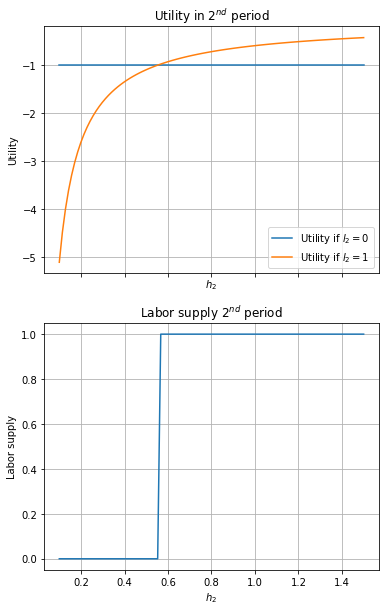

In [204]:
u2_nowork, u2_work, u2_opt, l2_opt = sol2(h_vec,rho,gamma,beta,w,b)

fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, sharex=True, figsize=(6,10))

# Sub_fig 1
ax1.plot(h_vec,u2_nowork, label='Utility if $l_2=0$')
ax1.plot(h_vec,u2_work, label='Utility if $l_2=1$')
#ax1.plot(h_vec,u2_opt, label='Optimal utility')

ax1.grid()
ax1.legend(loc='lower right')
ax1.set_xlabel('$h_2$')
ax1.set_ylabel('Utility')
ax1.set_title('Utility in $2^{nd}$ period');

ax2.plot(h_vec,l2_opt)
ax2.grid()
ax2.set_xlabel('$h_2$')
ax2.set_ylabel('Labor supply')
ax2.set_title('Labor supply $2^{nd}$ period');

**Question 2:** Solve the model in period 1 and illustrate the solution (including labor supply as a function of human capital).

In [201]:
h1_vec = h_vec.copy()

def sol1(h1_vec,rho,gamma,beta,w,b):
    def h2_exp(h1,l1):
        return h1 + l1 + 0.25


    def v2_exp(h2_exp,rho,gamma,w,b):
        v2 = []
        for i in range(len(h2_exp)):
            if h2_exp[i]>=h2_cutoff:
                v2.append(utility(w*h2_exp[i],rho)-gamma)
            if h2_exp[i]<h2_cutoff:
                v2.append(utility(b,rho))

        return v2

    #print(v2_exp(h2_exp(h1_vec,1),rho,gamma))

    def v1(h1,l1,rho,gamma,beta,w,b):
        if l1 == 0:
            return utility(b,rho) + beta*np.array(v2_exp(h2_exp(h1,l1),rho,gamma,w,b))
        if l1 == 1:
            return utility(w*h1,rho) - gamma + beta*np.array(v2_exp(h2_exp(h1,l1),rho,gamma,w,b))


    u1_nowork = v1(h1_vec,0,rho,gamma,beta,w,b)
    u1_work = v1(h1_vec,1,rho,gamma,beta,w,b)

    #print(u1_work,u1_nowork)

    def opt1(u1_nowork,u1_work):
        u1_opt = np.maximum(u1_work,u1_nowork)

        l1_opt = []
        for i in range(len(h_vec)):
            if u1_work[i]>=u1_nowork[i]:
                l1_opt.append(1)
            else:
                l1_opt.append(0)
        return u1_opt, l1_opt

    u1_opt, l1_opt = opt1(u1_nowork,u1_work)
    return u1_nowork, u1_work, u1_opt, l1_opt

#print(u1_opt, l1_opt)   

#######################
#######################

def sol1_2(h1_vec,rho,gamma,beta,w,b):
    u2_nowork_nowork = np.zeros(len(h_vec)) + v2(h2_exp(h1_vec,0),0,rho,gamma,w,b)
    #print(u2_nowork_nowork)
    u2_nowork_work = v2(h2_exp(h1_vec,0),1,rho,gamma,w,b)
    #print(u2_nowork_work)

    u2_opt_nowork1, l2_opt_nowork1 = opt2(u2_nowork_nowork,u2_nowork_work)

    #print(u2_opt_nowork1, l2_opt_nowork1)


    u2_work_nowork = np.zeros(len(h_vec)) + v2(h2_exp(h1_vec,1),0,rho,gamma,w,b)
    #print(u2_work_nowork)
    u2_work_work = v2(h2_exp(h1_vec,1),1,rho,gamma,w,b)
    #print(u2_work_work)

    u2_opt_work1, l2_opt_work1 = opt2(u2_work_nowork,u2_work_work)
    #print(u2_opt_work1, l2_opt_work1)
    return u2_opt_nowork1, l2_opt_nowork1, u2_opt_work1, l2_opt_work1


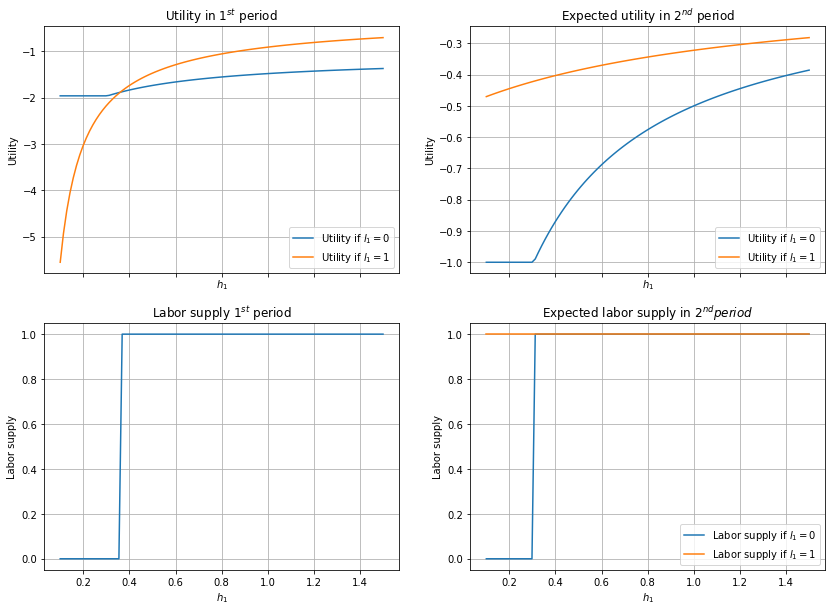

In [202]:
u1_nowork, u1_work, u1_opt, l1_opt = sol1(h1_vec,rho,gamma,beta,w,b)
u2_opt_nowork1, l2_opt_nowork1, u2_opt_work1, l2_opt_work1 = sol1_2(h1_vec,rho,gamma,beta,w,b)


fig, ((ax1, ax3), (ax2, ax4)) = plt.subplots(nrows=2, ncols=2, sharex=True, figsize=(14,10))

# Sub_fig 1
ax1.plot(h_vec,u1_nowork, label='Utility if $l_1=0$')
ax1.plot(h_vec,u1_work, label='Utility if $l_1=1$')
ax1.grid()
ax1.legend(loc='lower right')
ax1.set_xlabel('$h_1$')
ax1.set_ylabel('Utility')
ax1.set_title('Utility in $1^{st}$ period');

# Sub_fig2
ax2.plot(h_vec,l1_opt)
ax2.grid()
ax2.set_xlabel('$h_1$')
ax2.set_ylabel('Labor supply')
ax2.set_title('Labor supply $1^{st}$ period');

# Sub_fig3
ax3.plot(h_vec,u2_opt_nowork1, label='Utility if $l_1=0$')
ax3.plot(h_vec,u2_opt_work1, label='Utility if $l_1=1$')
ax3.grid()
ax3.legend(loc='lower right')
ax3.set_xlabel('$h_1$')
ax3.set_ylabel('Utility')
ax3.set_title('Expected utility in $2^{nd}$ period');

# Sub_fig4
ax4.plot(h_vec,l2_opt_nowork1, label='Labor supply if $l_1=0$')
ax4.plot(h_vec,l2_opt_work1, label='Labor supply if $l_1=1$')
ax4.grid()
ax4.legend(loc='lower right')
ax4.set_xlabel('$h_1$')
ax4.set_ylabel('Labor supply')
ax4.set_title('Expected labor supply in $2^{nd} period$');

**Question 3:** Will the worker never work if her potential wage income is lower than the unemployment benefits she can get? Explain and illustrate why or why not.

In [209]:
rho = 2
beta = 0.96
gamma = 0.1
Delta = 0.1
h1_vec = h_vec.copy()


def fig(w,b):
    u1_nowork, u1_work, u1_opt, l1_opt = sol1(h1_vec,rho,gamma,beta,w,b)
    u2_opt_nowork1, l2_opt_nowork1, u2_opt_work1, l2_opt_work1 = sol1_2(h1_vec,rho,gamma,beta,w,b)


    fig, (ax1, ax2, ax3) = plt.subplots(nrows=1, ncols=3, figsize=(16,6))

    # Sub_fig 1
    ax1.plot(h_vec,u1_nowork, label='Utility if $l_1=0$')
    ax1.plot(h_vec,u1_work, label='Utility if $l_1=1$')
    ax1.grid()
    ax1.legend(loc='lower right')
    ax1.set_xlabel('$h_1$')
    ax1.set_ylabel('Utility')
    ax1.set_title('Utility in $1^{st}$ period');

    # Sub_fig2
    ax2.plot(h_vec,l1_opt)
    ax2.grid()
    ax2.set_xlabel('$h_1$')
    ax2.set_ylabel('Labor supply')
    ax2.set_title('Labor supply $1^{st}$ period');

    # Sub_fig3
    ax3.plot(h_vec,l2_opt_nowork1, label='Labor supply if $l_1=0$')
    ax3.plot(h_vec,l2_opt_work1, label='Labor supply if $l_1=1$')
    ax3.grid()
    ax3.legend(loc='lower right')
    ax3.set_xlabel('$h_1$')
    ax3.set_ylabel('Labor supply')
    ax3.set_title('Expected labor supply in $2^{nd} period$');


widgets.interact(fig,
    b = widgets.IntSlider(
                    value=1,
                    description="Benefits", 
                    min=0,
                    max=5, 
                    step=0.5,
                    ),
    w = widgets.IntSlider(
                    valuse=2,
                    description="Wage", 
                    min=0,
                    max=5, 
                    step=0.5,
                    )
); 



interactive(children=(IntSlider(value=0, description='Wage', max=5, step=0), IntSlider(value=3, description='B…

# 2. AS-AD model

Consider the following **AS-AD model**. The **goods market equilibrium** is given by

$$ y_{t} = -\alpha r_{t} + v_{t} $$

where $y_{t}$ is the **output gap**, $r_{t}$ is the **ex ante real interest** and $v_{t}$ is a **demand disturbance**. 

The central bank's **Taylor rule** is

$$ i_{t} = \pi_{t+1}^{e} + h \pi_{t} + b y_{t}$$

where $i_{t}$ is the **nominal interest rate**, $\pi_{t}$ is the **inflation gap**, and $\pi_{t+1}^{e}$ is the **expected inflation gap**. 

The **ex ante real interest rate** is given by 

$$ r_{t} = i_{t} - \pi_{t+1}^{e} $$

Together, the above implies that the **AD-curve** is

$$ \pi_{t} = \frac{1}{h\alpha}\left[v_{t} - (1+b\alpha)y_{t}\right]$$

Further, assume that the **short-run supply curve (SRAS)** is given by

$$ \pi_{t} = \pi_{t}^{e} + \gamma y_{t} + s_{t}$$

where $s_t$ is a **supply disturbance**.

**Inflation expectations are adaptive** and given by

$$ \pi_{t}^{e} = \phi\pi_{t-1}^{e} + (1-\phi)\pi_{t-1}$$

Together, this implies that the **SRAS-curve** can also be written as

$$ \pi_{t} = \pi_{t-1} + \gamma y_{t} - \phi\gamma y_{t-1} + s_{t} - \phi s_{t-1} $$

The **parameters** of the model are:

In [4]:
par = {}

par['alpha'] = 5.76
par['h'] = 0.5
par['b'] = 0.5
par['phi'] = 0
par['gamma'] = 0.075

**Question 1:** Use the ``sympy`` module to solve for the equilibrium values of output, $y_t$, and inflation, $\pi_t$, (where AD = SRAS) given the parameters ($\alpha$, $h$, $b$, $\alpha$, $\gamma$) and $y_{t-1}$ , $\pi_{t-1}$, $v_t$, $s_t$, and $s_{t-1}$.

**Question 2:** Find and illustrate the equilibrium when $y_{t-1} = \pi_{t-1} = v_t = s_t = s_{t-1} = 0$. Illustrate how the equilibrium changes when instead $v_t = 0.1$.

**Persistent disturbances:** Now, additionaly, assume that both the demand and the supply disturbances are AR(1) processes

$$ v_{t} = \delta v_{t-1} + x_{t} $$
$$ s_{t} = \omega s_{t-1} + c_{t} $$

where $x_{t}$ is a **demand shock**, and $c_t$ is a **supply shock**. The **autoregressive parameters** are:

In [5]:
par['delta'] = 0.80
par['omega'] = 0.15

**Question 3:** Starting from $y_{-1} = \pi_{-1} = s_{-1} = 0$, how does the economy evolve for $x_0 = 0.1$, $x_t = 0, \forall t > 0$ and $c_t = 0, \forall t \geq 0$?

**Stochastic shocks:** Now, additionally, assume that $x_t$ and $c_t$ are stochastic and normally distributed

$$ x_{t}\sim\mathcal{N}(0,\sigma_{x}^{2}) $$
$$ c_{t}\sim\mathcal{N}(0,\sigma_{c}^{2}) $$

The **standard deviations of the shocks** are:

In [6]:
par['sigma_x'] = 3.492
par['sigma_c'] = 0.2

**Question 4:** Simulate the AS-AD model for 1,000 periods. Calculate the following five statistics:

1. Variance of $y_t$, $var(y_t)$
2. Variance of $\pi_t$, $var(\pi_t)$
3. Correlation between $y_t$ and $\pi_t$, $corr(y_t,\pi_t)$
4. Auto-correlation between $y_t$ and $y_{t-1}$, $corr(y_t,y_{t-1})$
5. Auto-correlation between $\pi_t$ and $\pi_{t-1}$, $corr(\pi_t,\pi_{t-1})$

**Question 5:** Plot how the correlation between $y_t$ and $\pi_t$ changes with $\phi$. Use a numerical optimizer or root finder to choose $\phi\in(0,1)$ such that the simulated correlation between $y_t$ and $\pi_t$ comes close to 0.31. 

**Quesiton 6:** Use a numerical optimizer to choose $\sigma_x>0$, $\sigma_c>0$ and $\phi\in(0,1)$ to make the simulated statistics as close as possible to US business cycle data where:

1. $var(y_t) = 1.64$
2. $var(\pi_t) = 0.21$
3. $corr(y_t,\pi_t) = 0.31$
4. $corr(y_t,y_{t-1}) = 0.84$
5. $corr(\pi_t,\pi_{t-1}) = 0.48$

# 3. Exchange economy

Consider an **exchange economy** with

1. 3 goods, $(x_1,x_2,x_3)$
2. $N$ consumers indexed by \\( j \in \{1,2,\dots,N\} \\)
3. Preferences are Cobb-Douglas with log-normally distributed coefficients

    $$ \begin{eqnarray*}
    u^{j}(x_{1},x_{2},x_{3}) &=& 
    \left(x_{1}^{\beta_{1}^{j}}x_{2}^{\beta_{2}^{j}}x_{3}^{\beta_{3}^{j}}\right)^{\gamma}\\
     &  & \,\,\,\beta_{i}^{j}=\frac{\alpha_{i}^{j}}{\alpha_{1}^{j}+\alpha_{2}^{j}+\alpha_{3}^{j}} \\
     &  & \,\,\,\boldsymbol{\alpha}^{j}=(\alpha_{1}^{j},\alpha_{2}^{j},\alpha_{3}^{j}) \\ 
     &  & \,\,\,\log(\boldsymbol{\alpha}^j) \sim \mathcal{N}(\mu,\Sigma) \\
    \end{eqnarray*} $$

4. Endowments are exponentially distributed,

$$
\begin{eqnarray*}
\boldsymbol{e}^{j} &=& (e_{1}^{j},e_{2}^{j},e_{3}^{j}) \\
 &  & e_i^j \sim f, f(z;\zeta) =  1/\zeta \exp(-z/\zeta)
\end{eqnarray*}
$$

Let $p_3 = 1$ be the **numeraire**. The implied **demand functions** are:

$$
\begin{eqnarray*}
x_{i}^{\star j}(p_{1},p_{2},\boldsymbol{e}^{j})&=&\beta^{j}_i\frac{I^j}{p_{i}} \\
\end{eqnarray*}
$$

where consumer $j$'s income is

$$I^j = p_1 e_1^j + p_2 e_2^j +p_3 e_3^j$$

The **parameters** and **random preferences and endowments** are given by:

In [7]:
# a. parameters
N = 50000
mu = np.array([3,2,1])
Sigma = np.array([[0.25, 0, 0], [0, 0.25, 0], [0, 0, 0.25]])
gamma = 0.8
zeta = 1

# b. random draws
seed = 1986
np.random.seed(seed)

# preferences
alphas = np.exp(np.random.multivariate_normal(mu, Sigma, size=N))
betas = alphas/np.reshape(np.sum(alphas,axis=1),(N,1))

# endowments
e1 = np.random.exponential(zeta,size=N)
e2 = np.random.exponential(zeta,size=N)
e3 = np.random.exponential(zeta,size=N)

**Question 1:** Plot the histograms of the budget shares for each good across agents.

Consider the **excess demand functions:**

$$ z_i(p_1,p_2) = \sum_{j=1}^N x_{i}^{\star j}(p_{1},p_{2},\boldsymbol{e}^{j}) - e_i^j$$

**Question 2:** Plot the excess demand functions.

**Quesiton 3:** Find the Walras-equilibrium prices, $(p_1,p_2)$, where both excess demands are (approximately) zero, e.g. by using the following tâtonnement process:

1. Guess on $p_1 > 0$, $p_2 > 0$ and choose tolerance $\epsilon > 0$ and adjustment aggressivity parameter, $\kappa > 0$.
2. Calculate $z_1(p_1,p_2)$ and $z_2(p_1,p_2)$.
3. If $|z_1| < \epsilon$ and $|z_2| < \epsilon$ then stop.
4. Else set $p_1 = p_1 + \kappa \frac{z_1}{N}$ and $p_2 = p_2 + \kappa \frac{z_2}{N}$ and return to step 2.

**Question 4:** Plot the distribution of utility in the Walras-equilibrium and calculate its mean and variance.

**Question 5:** Find the Walras-equilibrium prices if instead all endowments were distributed equally. Discuss the implied changes in the distribution of utility. Does the value of $\gamma$ play a role for your conclusions?